In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet18
import matplotlib.pyplot as plt

In [12]:
# Device setup: gunakan GPU jika tersedia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Augmentation dan Normalisasi
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Grayscale
    transforms.Resize((48, 48)),  # Resize ke 48x48
    transforms.RandomHorizontalFlip(),  # Random flip horizontal
    transforms.RandomRotation(10),  # Rotasi hingga 10 derajat
    transforms.RandomCrop(48, padding=4, pad_if_needed=True),  # Random crop dengan padding
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalisasi
])

# Path ke folder dataset
train_dir = "dataset/train"
test_dir = "dataset/test"

# Dataset dan DataLoader
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Membagi train_dataset menjadi train dan validation set
train_size = int(0.8 * len(train_dataset))  # 80% untuk training
val_size = len(train_dataset) - train_size  # 20% untuk validation
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# DataLoader untuk train, validation, dan test
batch_size = 64
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [13]:

# Model ResNet18 (Transfer Learning)
model = resnet18(pretrained=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Modifikasi input layer untuk grayscale
model.fc = nn.Linear(model.fc.in_features, 7)  # Ganti layer terakhir untuk 7 kelas
model.to(device)

# Loss function dan optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Scheduler (One-Cycle Learning Rate)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=40)

# Early stopping parameters
patience = 3
best_val_accuracy = 0.0
early_stop_counter = 0

# Logging for visualization
train_losses = []
val_losses = []
val_accuracies = []

In [14]:
# Training dan evaluasi
num_epochs = 40
for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss += loss.item()

    # Validasi
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total

    # Logging untuk grafik
    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss/len(train_loader):.4f}, "
          f"Val Loss: {val_loss/len(val_loader):.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Early stopping
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        early_stop_counter = 0
        # Simpan model terbaik
        torch.save(model.state_dict(), "best_model.pth")
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping...")
            break
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

Epoch 1/40, Train Loss: 1.7028, Val Loss: 1.5883, Val Accuracy: 0.3983
Epoch 2/40, Train Loss: 1.4789, Val Loss: 1.4981, Val Accuracy: 0.4422
Epoch 3/40, Train Loss: 1.4819, Val Loss: 1.5081, Val Accuracy: 0.4443
Epoch 4/40, Train Loss: 1.5607, Val Loss: 1.5760, Val Accuracy: 0.3918
Epoch 5/40, Train Loss: 1.4880, Val Loss: 1.4410, Val Accuracy: 0.4425
Epoch 6/40, Train Loss: 1.4139, Val Loss: 1.4072, Val Accuracy: 0.4768
Epoch 7/40, Train Loss: 1.3895, Val Loss: 1.4364, Val Accuracy: 0.4552
Epoch 8/40, Train Loss: 1.3226, Val Loss: 1.5224, Val Accuracy: 0.4345
Epoch 9/40, Train Loss: 1.3545, Val Loss: 1.3493, Val Accuracy: 0.4861
Epoch 10/40, Train Loss: 1.2840, Val Loss: 1.3173, Val Accuracy: 0.4943
Epoch 11/40, Train Loss: 1.2457, Val Loss: 1.2812, Val Accuracy: 0.5094
Epoch 12/40, Train Loss: 1.2178, Val Loss: 1.2327, Val Accuracy: 0.5338
Epoch 13/40, Train Loss: 1.1940, Val Loss: 1.2265, Val Accuracy: 0.5340
Epoch 14/40, Train Loss: 1.1681, Val Loss: 1.2207, Val Accuracy: 0.5432
E

C:\Users\Legion\AppData\Local\Temp\ipykernel_47272\4118936056.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


Test Accuracy: 0.6239


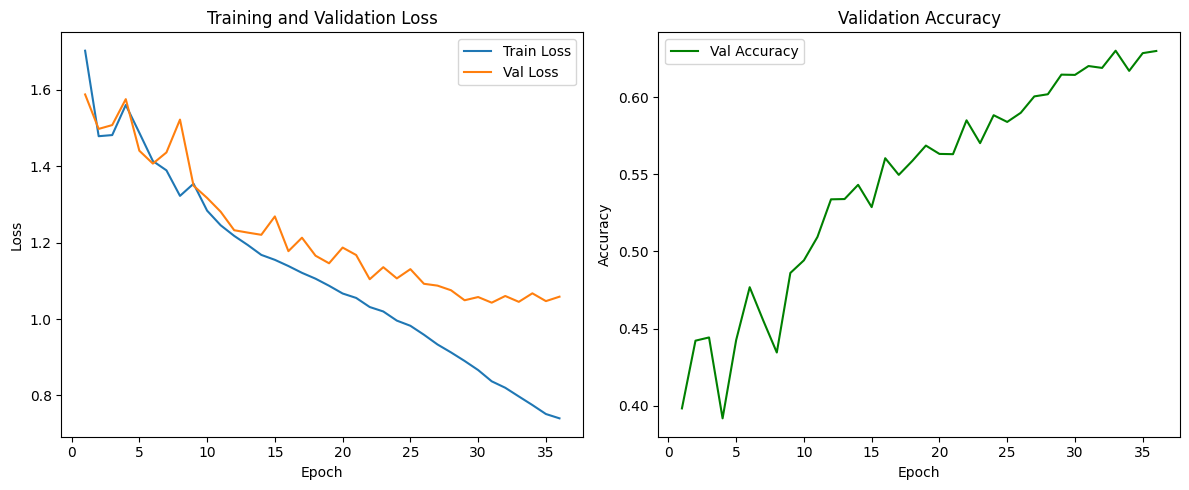

In [15]:
test_accuracy = test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.4f}")

# Visualisasi grafik
plt.figure(figsize=(12, 5))

# Plot Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Val Accuracy", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()